### 1. Environment Settings

#### 1.1 Import Library

In [1]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

2023-01-18 15:21:03.957111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 15:21:04.143359: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-18 15:21:04.181233: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-18 15:21:04.944467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### 1.2 Setting Default Value

In [2]:
data_path = "/home/lamda_00/Depression_paper/data/"
model_path = "/home/lamda_00/Depression_paper/model/"
ckpt_path = "/home/lamda_00/Depression_paper/ckpt/"
config_path = "/home/lamda_00/Depression_paper/config/"
log_path = "/home/lamda_00/Depression_paper/log/"
config_file = "bert-base.json"

#### 1.3 Load Dataset 

In [3]:
bws_score = pd.read_csv(os.path.join(data_path, 'bws_sim_score1.csv'))
bws_score.head(3)

,text,translated,cnt,weakest_cnt,strongest_cnt,score,minmax_score,label
0,i am sad for both of them and i hope something...,나는 그들 모두에게 슬프고 나는 무언가가 더 나은 방향으로 바뀌기를 바란다,8,0,3,0.375,0.6875,11
1,it feels like all i ever achieve through what ...,불행함을 느끼지 않기 위해 내가 힘든 노력으로 느끼는 것을 통해 내가 성취하는 모든...,8,0,0,0.000,0.5000,8
2,so yet again i lose the person that i tell eve...,그래서 다시 나는 내가 모든 것을 말할 수 있는 사람을 잃고 우울할 때 기분이 나아...,8,0,0,0.000,0.5000,8


In [4]:
bws_score = bws_score[['text', 'translated', 'label']]
bws_score.columns = ['text', 'text_kor', 'label']
bws_score.head(1)

,text,text_kor,label
0,i am sad for both of them and i hope something...,나는 그들 모두에게 슬프고 나는 무언가가 더 나은 방향으로 바뀌기를 바란다,11


In [5]:
X_train, X_test = train_test_split(bws_score, test_size=0.2, random_state=42)
X_train, X_dev = train_test_split(X_train, test_size=0.1, random_state=42)
len(X_train), len(X_dev), len(X_test)

(1152, 128, 320)

In [6]:
X_train.to_csv(os.path.join(data_path, 'bws_score_train.csv'), index=False)
X_dev.to_csv(os.path.join(data_path, 'bws_score_val.csv'), index=False)
X_test.to_csv(os.path.join(data_path, 'bws_score_test.csv'), index=False)

#### 1.4 Load Pretrained model & tokenizer 

In [201]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-tiny'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-tiny', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-tiny'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [202]:
model_path

'/home/lamda_00/Depression_paper/model/'

In [203]:
config.attention_probs_dropout_prob, config.hidden_size

(0.1, 128)

In [204]:
config

BertConfig {
  "_name_or_path": "/home/lamda_00/Depression_paper/model/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 1.5 setting training args & config 

In [205]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [206]:
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [207]:
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 32, 'device': device(type='cuda'), 'eval_batch_size': 32, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.0, 'adam_epsilon': 1e-08, 'warmup_proportion': 0, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100})

In [208]:
training_config.learning_rate

5e-05

### 2. Define Class

In [209]:
training_config.pad = 'max_length'
training_config.num_epochs = 500

In [210]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [211]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                # print('input label 오류')
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [212]:
training_config.num_epochs
training_config

AttrDict({'default_path': '../', 'data_path': 'data', 'log_path': 'log', 'model_path': 'model', 'config_path': 'config', 'seed': 42, 'train_batch_size': 32, 'device': device(type='cuda'), 'eval_batch_size': 32, 'num_epochs': 500, 'gradient_accumulation_steps': 1, 'max_grad_norm': 1.0, 'adam_epsilon': 1e-08, 'warmup_proportion': 0, 'learning_rate': 5e-05, 'do_lower_case': False, 'no_cuda': False, 'max_steps': -1, 'logging_steps': 100, 'pad': 'max_length'})

In [213]:
config.hidden_size

128

In [214]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [215]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        # print(f'logits: {len(logits)}, {len(logits[0])}')
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        # print(f'score: {score}')
        return score 

In [216]:
class BertTrainer():
    def __init__(self, config, training_config, model, train_dataloader, eval_dataloader):
        self.config = config
        self.training_config = training_config
        self.model = model
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        
    def set_seed(self):
        random.seed(self.training_config.seed)
        np.random.seed(self.training_config.seed)
        torch.manual_seed(self.training_config.seed)
        if not self.training_config.no_cuda and torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.training_config.seed)
    
    def train(self):
        global_step = 0; nb_eval_steps = 0
        train_rmse = []; eval_rmse = []
        t_total = len(self.train_dataloader) // self.training_config.gradient_accumulation_steps * self.training_config.num_epochs

        optimizer = AdamW(self.model.parameters(), lr=self.training_config.learning_rate, eps=self.training_config.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * self.training_config.warmup_proportion), \
                                                    num_training_steps=t_total)
        
        criterion = RMSELoss
        # criterion = nn.MSELoss()
        best_loss = 9999 
        
        self.model.zero_grad()
        for epoch in range(int(self.training_config.num_epochs)):
            train_loss = 0.0; eval_loss = 0.0 
            
            for step, batch in enumerate(self.train_dataloader):
                self.model.train()
                batch = tuple(t.to(self.training_config.device) for t in batch)
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                # print(f'output: {type(outputs)}, {outputs.squeeze}')
                label = batch[3]
                # print(f'label: {label}')
                # print(f'output: {outputs}, {outputs.squeeze()}')
                loss = criterion(outputs.squeeze(), batch[3].type_as(outputs))
                loss.backward()
                
                train_loss += loss.item()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.training_config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                
                self.model.zero_grad()
            
            print(f'epoch: {epoch + 1} done, train_loss: {train_loss / len(self.train_dataloader)}')
            train_rmse.append(train_loss / len(self.train_dataloader))

            for step2, batch2 in enumerate(self.eval_dataloader):
                self.model.eval()
                batch2 = tuple(t.to(self.training_config.device) for t in batch2)

                with torch.no_grad():
                    inputs = {
                        "input_ids": batch2[0],
                        "attention_mask": batch2[1],
                        "token_type_ids": batch2[2],
                    }
                    label2 = batch2[3]
                    outputs = self.model(**inputs)
                    tmp_eval_loss = criterion(outputs.squeeze(), label2.type_as(outputs))
                    eval_loss += tmp_eval_loss.mean().item()
                    
                nb_eval_steps += 1

            eval_loss = eval_loss / nb_eval_steps
            eval_rmse.append(eval_loss)
            if eval_loss < best_loss:
                best_loss = eval_loss
                es = 0
                print(f'save best loss state model & log(epoch {epoch + 1})')
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_{epoch}.pt'))
            else:
                es += 1
                print("Counter {} of 5".format(es))

            if es > 4:
                print("Early stopping with best_loss: ", best_loss, "and val_loss for this epoch: ", eval_loss, "...")
                self.save_model(os.path.join(self.training_config.default_path, self.training_config.model_path, f'bert_bws_best.pt'))
                break
        self.save_log(train_rmse, eval_rmse, epoch+1)
        return train_rmse, eval_rmse
            
    def save_log(self, train_mse, eval_mse, epoch):
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'train_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(train_mse, f, pickle.HIGHEST_PROTOCOL)  
        
        with open(os.path.join(self.training_config.default_path, self.training_config.log_path, f'eval_{epoch}_mse.pickle'), 'wb') as f:
            pickle.dump(eval_mse, f, pickle.HIGHEST_PROTOCOL)  
    
    def save_model(self, model_name):
        torch.save(self.model.state_dict(), model_name)

### 3. Model Train

In [217]:
X_train.label.unique()

array([13, 10,  9,  0,  8,  1, 15, 12, 14, 16, 11,  3,  7,  6,  2,  4,  5])

In [218]:
train_file = BertDataset(X_train)
val_file = BertDataset(X_dev)

In [219]:
len(train_file), len(val_file)

(1152, 128)

In [220]:
config.max_position_embeddings = 32
config.max_position_embeddings

32

In [221]:
bert_processor = BertProcessor(config, training_config, tokenizer)

In [222]:
train_dataset = bert_processor.convert_data(train_file)
val_dataset = bert_processor.convert_data(val_file)

In [223]:
train_sampler = bert_processor.shuffle_data(train_dataset, 'train')
val_sampler = bert_processor.shuffle_data(val_dataset, 'eval')

In [224]:
train_dataloader = bert_processor.load_data(train_dataset, train_sampler)
val_dataloader = bert_processor.load_data(val_dataset, val_sampler)

In [225]:
len(train_dataloader), len(val_dataloader)

(36, 4)

In [226]:
model_reg = BertRegressor(config, model).to(training_config.device)  

In [227]:
bert_trainer = BertTrainer(config, training_config, model_reg, train_dataloader, val_dataloader)

In [228]:
train_mse, eval_mse = bert_trainer.train()

epoch: 1 done, train_loss: 8.730203549067179
save best loss state model & log(epoch 1)
epoch: 2 done, train_loss: 7.522732986344232
save best loss state model & log(epoch 2)
epoch: 3 done, train_loss: 6.752065645323859
save best loss state model & log(epoch 3)
epoch: 4 done, train_loss: 6.193689187367757
save best loss state model & log(epoch 4)
epoch: 5 done, train_loss: 5.542160458034939
save best loss state model & log(epoch 5)
epoch: 6 done, train_loss: 4.758662270175086
save best loss state model & log(epoch 6)
epoch: 7 done, train_loss: 4.044101489914788
save best loss state model & log(epoch 7)
epoch: 8 done, train_loss: 3.4134022262361317
save best loss state model & log(epoch 8)
epoch: 9 done, train_loss: 2.9464251034789615
save best loss state model & log(epoch 9)
epoch: 10 done, train_loss: 2.680649767319361
save best loss state model & log(epoch 10)
epoch: 11 done, train_loss: 2.4707671966817646
save best loss state model & log(epoch 11)
epoch: 12 done, train_loss: 2.441190

epoch: 99 done, train_loss: 0.6764412017332183
save best loss state model & log(epoch 99)
epoch: 100 done, train_loss: 0.6300304209192594
Counter 1 of 5
epoch: 101 done, train_loss: 0.6813581710060438
save best loss state model & log(epoch 101)
epoch: 102 done, train_loss: 0.636998159190019
save best loss state model & log(epoch 102)
epoch: 103 done, train_loss: 0.6548252147105005
save best loss state model & log(epoch 103)
epoch: 104 done, train_loss: 0.6984443813562393
Counter 1 of 5
epoch: 105 done, train_loss: 0.6510748101605309
save best loss state model & log(epoch 105)
epoch: 106 done, train_loss: 0.6431237492296431
save best loss state model & log(epoch 106)
epoch: 107 done, train_loss: 0.6486574593517516
Counter 1 of 5
epoch: 108 done, train_loss: 0.6421058550477028
save best loss state model & log(epoch 108)
epoch: 109 done, train_loss: 0.6274502260817422
save best loss state model & log(epoch 109)
epoch: 110 done, train_loss: 0.6622166418366962
save best loss state model & l

epoch: 202 done, train_loss: 0.457380344470342
save best loss state model & log(epoch 202)
epoch: 203 done, train_loss: 0.44554927365647423
Counter 1 of 5
epoch: 204 done, train_loss: 0.4592753541138437
Counter 2 of 5
epoch: 205 done, train_loss: 0.4511765291293462
save best loss state model & log(epoch 205)
epoch: 206 done, train_loss: 0.4554980562792884
save best loss state model & log(epoch 206)
epoch: 207 done, train_loss: 0.4566250716646512
save best loss state model & log(epoch 207)
epoch: 208 done, train_loss: 0.4588734399941232
save best loss state model & log(epoch 208)
epoch: 209 done, train_loss: 0.4268709404600991
Counter 1 of 5
epoch: 210 done, train_loss: 0.4559331031309234
save best loss state model & log(epoch 210)
epoch: 211 done, train_loss: 0.42838386197884876
Counter 1 of 5
epoch: 212 done, train_loss: 0.4763445349203216
Counter 2 of 5
epoch: 213 done, train_loss: 0.4453582829899258
save best loss state model & log(epoch 213)
epoch: 214 done, train_loss: 0.432035492

epoch: 308 done, train_loss: 0.3538840123348766
Counter 3 of 5
epoch: 309 done, train_loss: 0.3826797923280133
save best loss state model & log(epoch 309)
epoch: 310 done, train_loss: 0.3336207614176803
save best loss state model & log(epoch 310)
epoch: 311 done, train_loss: 0.36390185521708596
Counter 1 of 5
epoch: 312 done, train_loss: 0.34973593594299424
save best loss state model & log(epoch 312)
epoch: 313 done, train_loss: 0.3774471580982208
Counter 1 of 5
epoch: 314 done, train_loss: 0.35882802431782085
Counter 2 of 5
epoch: 315 done, train_loss: 0.35836147020260495
Counter 3 of 5
epoch: 316 done, train_loss: 0.35151588833994335
save best loss state model & log(epoch 316)
epoch: 317 done, train_loss: 0.3854202495680915
save best loss state model & log(epoch 317)
epoch: 318 done, train_loss: 0.3921714992158943
Counter 1 of 5
epoch: 319 done, train_loss: 0.36496928830941516
Counter 2 of 5
epoch: 320 done, train_loss: 0.3385783988568518
Counter 3 of 5
epoch: 321 done, train_loss: 0

In [199]:
# bert_trainer.save_model(os.path.join(model_path, 'bert_class.pt'))

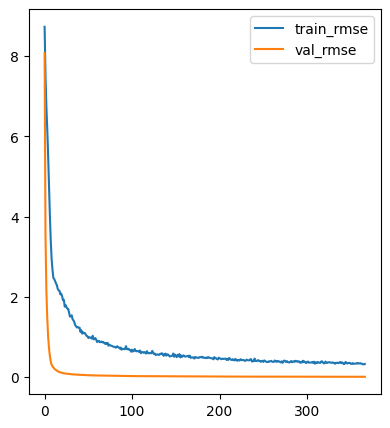

In [229]:
num_epochs = list(range(len(train_mse)))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_mse))), train_mse, label='train_rmse')
plt.plot(list(range(len(eval_mse))), eval_mse, label='val_rmse')

plt.legend()
plt.show()

### 3. Model Test 

In [45]:
X_test = pd.read_csv(os.path.join(data_path, 'bws_score_test.csv'))
X_test

,text,text_kor,label
0,i've tried to ignore my feelings but i really ...,나는 내 감정을 무시하려고 노력했지만 정말 우울하다,14
1,to about ish and my mothers just been getting ...,나는 그녀에게 우울증이 있다고 말했고 그녀는 내가 더 일찍 일어나야 한다고 말했고 ...,10
2,at the apex we feel something at the trough we...,정점에서 우리는 무언가를 느낀다 우리는 우울하게 느끼는 무언가를 느낀다,8
3,i don't think i am depressed or suicidal but v...,나는 내가 우울하거나 자살했다고 생각하지 않지만 매우 매우 지루하고 혼자라고 생각한다,11
4,now that my ankle is healed though i feel depr...,다시 우울해지긴 했지만 발목이 다 나았으니,9
...,...,...,...
315,upon receiving the news each time i've been un...,매번 그 소식을 듣자마자 나는 울거나 슬퍼할 수 없었다,8
316,Why are you doing this when you're not even dr...,술도 안 취했는데 왜 이러는 거야?,0
317,whenever i feel lonely i go here only to reali...,내가 외로울 때마다 나는 내가 아니라는 것을 깨달았을 뿐이다,9
318,"During the training, I was able to get my grad...","훈련 기간 동안, 나는 5등까지 성적을 올릴 수 있었다",0


In [46]:
config.max_position_embeddings = 32

In [47]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

In [48]:
training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [49]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    # def clear_text(self)  => 전처리 코드를 여기에 넣을 경우 상당히 느려짐
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [50]:
class BertRegressor(nn.Module):
    def __init__(self, config, model):
        super(BertRegressor, self).__init__()
        self.model = model
        self.linear = nn.Linear(config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.out = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        x = self.linear(logits)
        x = self.relu(x)
        score = self.out(x)
        return score 

In [51]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification

        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def convert_sentence(self, sent_list):   # 사용자 입력 문장 1개 -> 입력 형태 변환
        context2 = None 
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(sent_list, context2)], max_length=self.max_len, padding=self.pad, truncation=self.truncation
        )
        
        features = []
        inputs = {k: batch_encoding[k][0] for k in batch_encoding}
        inputs['label'] = 0 
        features.append(inputs)

        input_id = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        input_am = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        input_tts = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        input_lb = torch.tensor([f['label'] for f in features], dtype=torch.long)
        dataset = TensorDataset(input_id, input_am, input_tts, input_lb)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [52]:
class BertTester():
    def __init__(self, training_config, model):
        self.training_config = training_config
        self.model = model

    def get_label(self, test_dataloader, test_type):
        '''
        test_type: 0  -> Test dataset 
        test_type: 1  -> Test sentence
        '''
        preds = []
        labels = []

        for batch in test_dataloader:
            self.model.eval()   # self 안 붙이면 이상한 Output (BaseModelOutputWithPoolingAndCrossAttentions) 출력 
            batch = tuple(t.to(training_config.device) for t in batch)   # args.device: cuda 
            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                }
                outputs = self.model(**inputs)
                if test_type == 0:
                    preds.extend(outputs.squeeze().detach().cpu().numpy())
                elif test_type == 1:
                    preds.extend(outputs[0].detach().cpu().numpy())            
            label = batch[3].detach().cpu().numpy()
            labels.extend(label)
        return preds, labels 

In [122]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-tiny'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-tiny', 'bert_config.json'))
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-tiny'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-mini were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
test_processor = BertProcessor(config, training_config, tokenizer)

In [54]:
test_file = BertDataset(X_test)
test_dataset = test_processor.convert_data(test_file)
test_sampler = test_processor.shuffle_data(test_dataset, 'test')
test_dataloader = test_processor.load_data(test_dataset, test_sampler)

In [1]:
model_reg = BertRegressor(config, model)

NameError: name 'BertRegressor' is not defined

In [124]:
model_name = os.path.join(model_path, 'bert_bws_best.pt')

In [125]:
model_reg.load_state_dict(torch.load(model_name))
model_reg.to(training_config.device)

BertRegressor(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=Tru

In [126]:
bert_tester = BertTester(training_config, model_reg)

In [127]:
X_test.text[0]

"i've tried to ignore my feelings but i really am depressed"

In [128]:
y_pred, y_true = bert_tester.get_label(test_dataloader, 0)

In [129]:
list(map(int, y_pred))[:10], y_true[:10]

([10, 9, 8, 12, 9, 6, 0, 9, 8, 12], [14, 10, 8, 11, 9, 0, 0, 12, 8, 10])

In [130]:
len(test_dataloader), len(X_test), len(X_test) / 32

(10, 320, 10.0)

In [131]:
len(y_pred), len(y_true)

(320, 320)

In [132]:
y_true[:5], y_pred[:5]

([14, 10, 8, 11, 9], [10.677643, 9.397481, 8.988688, 12.5328245, 9.325927])

with open(os.path.join(data_path, 'conv.pickle'), 'rb') as f:
    conv = pickle.load(f)

In [118]:
with open(os.path.join(data_path, 'conv_translated.pickle'), 'wb') as f:
    pickle.dump(conv, f, pickle.HIGHEST_PROTOCOL)  

In [440]:
with open(os.path.join(data_path, 'conv_translated.pickle'), 'rb') as f:
    conv = pickle.load(f)

conv

,turn_cnt,speaker_idx,text,translated
0,1,User,안녕,hey
1,2,Chatbot,안녕하세요 ~ 반가워요,"Hello, nice to meet you"
2,3,User,이름이 뭐야 ?,what is your name ?
3,4,Chatbot,"저는 심리상담 챗봇, ~ 에요",I am a psychological counseling chatbot
4,5,User,아하 ㅎㅎ,Ah-huh
5,6,Chatbot,좋은 아침이에요,good morning
6,7,User,오늘 너무 우울하다,I'm so depressed today
7,8,Chatbot,무슨 일 있어요 ?,What's wrong?
8,9,User,그냥 요즘 너무 무기력한거 같아,I just feel so lethargic these days
9,10,Chatbot,무기력할 때는 몸을 움직여야 해요,"When you're lethargic, you have to move your body"


In [441]:
conv = conv[['speaker_idx', 'translated']]
conv.columns = ['speaker', 'text']
conv.head()

,speaker,text
0,User,hey
1,Chatbot,"Hello, nice to meet you"
2,User,what is your name ?
3,Chatbot,I am a psychological counseling chatbot
4,User,Ah-huh


In [442]:
conv_list = conv.text.values.tolist()
conv_list

['hey',
 'Hello, nice to meet you',
 'what is your name ?',
 'I am a psychological counseling chatbot',
 'Ah-huh',
 'good morning',
 "I'm so depressed today",
 "What's wrong?",
 'I just feel so lethargic these days',
 "When you're lethargic, you have to move your body",
 "I think he's psychologically exhausted",
 "I think you're really tired Is your work very hard?",
 "I can't sleep because I have too much work to do",
 "I think it's good to take a break for a while",
 "I should I'll go for a walk from time to time",
 'Taking a walk is good',
 'Thanks for listening',
 'Yes! See you next time']

In [446]:
conv_list = conv.text.values.tolist()

conv_result = [] 
for text in conv_list: 
    conv_dataset = test_processor.convert_sentence(text)
    conv_sampler = test_processor.shuffle_data(conv_dataset, 'test')
    conv_dataloader = test_processor.load_data(conv_dataset, conv_sampler)
    y_pred, y_true = bert_tester.get_label(conv_dataloader, 1)
    conv_result.append(int(y_pred[0]))

In [447]:
conv['predict'] = conv_result
conv

/tmp/ipykernel_10172/2549851626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conv['predict'] = conv_result


,speaker,text,predict
0,User,hey,0
1,Chatbot,"Hello, nice to meet you",0
2,User,what is your name ?,0
3,Chatbot,I am a psychological counseling chatbot,4
4,User,Ah-huh,0
5,Chatbot,good morning,0
6,User,I'm so depressed today,10
7,Chatbot,What's wrong?,0
8,User,I just feel so lethargic these days,7
9,Chatbot,"When you're lethargic, you have to move your body",0


In [139]:
test_sent = "I'm very ok" # X_test.text[0]
test_data = test_processor.convert_sentence(test_sent)
test_sampler = test_processor.shuffle_data(test_data, 'test')
test_loader = test_processor.load_data(test_data, test_sampler)

In [140]:
y_pred, y_true = bert_tester.get_label(test_loader, 1)
y_pred

[0.026226647]